### Augmenting Data

In [333]:
# Imports
import os 
from predictionguard import PredictionGuard
import pandas as pd 
import json
from langchain.prompts import PromptTemplate, FewShotPromptTemplate
import numpy as np
from torch import nn
from skorch import NeuralNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
from torch.optim import Adam
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [72]:
# Grief Journey Map
JourneyMap = {
    "1. Immediate Grief, Shock, and Emotion": "Overwhelmed, loss of purpose; shock and trauma emotions (isolation) present and challenging to understand. Individuals may struggle to deal with family responsibilities alone. Surviving Child: Feeling disconnected without guidance and attention from grieving adults.", 

    "2. Navigating Family Relationships": "Experiencing tension between individuals within the family unit; lack of support from family members. Surviving Family Unit: Perception of other family members’ grief experience. Each family member may be at different phases of their grief journey.",

    "3. Learning to Process Grief": "Experiencing grief and learning to process those emotions. Surviving Child: Seeks guidance and acknowledgment of grief; benefit from opportunities to open up and process with kids in similar situations to normalize emotions.", 

    "4. Moments That Matter": "Renewed experience of grief around anniversaries of loss, holidays, and special moments. Surviving Family Unit: Navigating special moments (sports, school achievements, moments that matter).", 

    "5. Feeling Immersed, Connected & Seen": "Finding new purpose and goals to begin moving towards Positive Integration. Surviving Family Unit: Connected to a broader community; support system; not the only person/family experiencing loss.", 

    "6. New Growth & Purpose": "Healthy point in grief journey; feeling capable to help others and a desire to do so. Surviving Family Unit: Ready to give back to the TAPS community through mentorship programs, volunteering at charity drives & events, etc." 
    }

dict = {
    "Stage Number": [int(key.split('.')[0]) for key in JourneyMap.keys()],
    "Stage Name": [key.split('. ', 1)[1] for key in JourneyMap.keys()],
    "Description": JourneyMap.values()
}

JourneyMapDF = pd.DataFrame(dict)
JourneyMapDF.set_index("Stage Number", inplace=True)
JourneyMapDF.head()

,Stage Name,Description
Stage Number,,
1,"Immediate Grief, Shock, and Emotion","Overwhelmed, loss of purpose; shock and trauma..."
2,Navigating Family Relationships,Experiencing tension between individuals withi...
3,Learning to Process Grief,Experiencing grief and learning to process tho...
4,Moments That Matter,Renewed experience of grief around anniversari...
5,"Feeling Immersed, Connected & Seen",Finding new purpose and goals to begin moving ...


In [26]:
# Survey Questions
SurveyQuestions = [
    {
        "question": "Please share all of the reasons you chose to attend the TAPS [SEMINAR NAME]",
        "options": [
            "I had attended a previous Regional or Nationals seminar",
            "To connect with other survivors who share a similar loss",
            "To learn more about resources TAPS has to offer",
            "To learn new tools and information to help me with my grief",
            "To learn more about how to support my adult family members in their grief",
            "To learn more about how to support my child(ren) in their grief",
            "For my child(ren) to attend Good Grief Camp",
            "For my child(ren) to connect with a Military Mentor"
        ],
        "type": "multiple_choice"
    },
    {
        "question": "How did you find out about the TAPS [SEMINAR NAME]?",
        "options": [
            "I found this event while searching for grief resources",
            "I attended a seminar last year and had already marked my calendar!",
            "TAPS invited me to this event via email",
            "My TAPS Survivor Care Team Member invited me",
            "My Peer Mentor or another survivor invited me",
            "Through the TAPS website",
            "Through the TAPS magazine",
            "Through a TAPS Social Media Page"
        ],
        "type": "multiple_choice"
    },
    {
        "question": "This seminar helped me to feel socially connected",
        "options": ["Disagree", "Neither agree nor disagree", "Agree"],
        "type": "likert"
    },
    {
        "question": "This seminar taught me new ways to cope with my grief",
        "options": ["Disagree", "Neither agree nor disagree", "Agree"],
        "type": "likert"
    },
    {
        "question": "This seminar helped me to better understand my grief",
        "options": ["Disagree", "Neither agree nor disagree", "Agree"],
        "type": "likert"
    },
    {
        "question": "This seminar has given me hope for the future",
        "options": ["Disagree", "Neither agree nor disagree", "Agree"],
        "type": "likert"
    },
    {
        "question": "Based on your experience at the TAPS [SEMINAR NAME], how likely are you to continue to connect with TAPS virtually / at in-person programs?",
        "options": [
            "Extremely likely / Very likely",
            "Somewhat likely",
            "Neither likely nor unlikely / Neutral",
            "Somewhat unlikely",
            "Extremely unlikely / Not at all likely"
        ],
        "type": "likelihood"
    },
    {
        "question": "Based on your experience at the TAPS [SEMINAR NAME], how likely are you to continue to bring your child(ren) to connect with TAPS at in-person programs?",
        "options": [
            "Extremely likely / Very likely",
            "Somewhat likely",
            "Neither likely nor unlikely / Neutral",
            "Somewhat unlikely",
            "Extremely unlikely / Not at all likely"
        ],
        "type": "likelihood"
    },
    {
        "question": "I have a positive outlook toward life",
        "options": ["Strongly Disagree", "Disagree", "Agree", "Strongly Agree"],
        "type": "likert"
    },
    {
        "question": "I have short and/or long range goals",
        "options": ["Strongly Disagree", "Disagree", "Agree", "Strongly Agree"],
        "type": "likert"
    },
    {
        "question": "I feel all alone",
        "options": ["Strongly Disagree", "Disagree", "Agree", "Strongly Agree"],
        "type": "likert"
    },
    {
        "question": "I can see possibilities in the midst of difficulties",
        "options": ["Strongly Disagree", "Disagree", "Agree", "Strongly Agree"],
        "type": "likert"
    },
    {
        "question": "I have faith that gives me comfort",
        "options": ["Strongly Disagree", "Disagree", "Agree", "Strongly Agree"],
        "type": "likert"
    },
    {
        "question": "I feel scared about my future",
        "options": ["Strongly Disagree", "Disagree", "Agree", "Strongly Agree"],
        "type": "likert"
    },
    {
        "question": "I can recall happy/joyful times",
        "options": ["Strongly Disagree", "Disagree", "Agree", "Strongly Agree"],
        "type": "likert"
    },
    {
        "question": "I have deep inner strength",
        "options": ["Strongly Disagree", "Disagree", "Agree", "Strongly Agree"],
        "type": "likert"
    },
    {
        "question": "I am able to give and receive care/love",
        "options": ["Strongly Disagree", "Disagree", "Agree", "Strongly Agree"],
        "type": "likert"
    },
    {
        "question": "I have a sense of direction",
        "options": ["Strongly Disagree", "Disagree", "Agree", "Strongly Agree"],
        "type": "likert"
    },
    {
        "question": "I believe that each day has potential",
        "options": ["Strongly Disagree", "Disagree", "Agree", "Strongly Agree"],
        "type": "likert"
    },
    {
        "question": "I feel my life has value and worth",
        "options": ["Strongly Disagree", "Disagree", "Agree", "Strongly Agree"],
        "type": "likert"
    },
    {
        "question": "Please share with TAPS your favorite moment of the weekend? Did you have a breakthrough moment this weekend you would like to share?",
        "type": "free_text"
    },
    {
        "question": "Please share any additional feedback you have regarding your TAPS Seminar experience.",
        "type": "free_text"
    }
]


In [177]:
# Training Data Import
data = pd.read_csv("examples.csv")
data.columns

Index(['Id', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10',
       'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18', 'q19', 'q20',
       'q21', 'q22', 'label'],
      dtype='object')

In [197]:
responses_df = pd.DataFrame(columns=data.columns)

for run_id in range(100):
    for stage, description in JourneyMap.items():
        stage_number = int(stage.split('.')[0])
        stagename = stage.split('.', 1)[1]
        responses = {"Id": f"{run_id}_{stagename}", 
                     "label": stage_number}
        
        for question_index, question_data in enumerate(SurveyQuestions[0:20]):
            question_text = question_data["question"]
            options = question_data["options"]

            options_text = "\n".join([f"{i}. {option}" for i, option in enumerate(options)])

            messages = [
            {
                "role": "system", 
                "content": f"You are a person who has had a death in the military or veteran community (at some point in time). Your current stage of grief is {stagename}: {description} You are asked by the Tragedy Assistance Program for Survivors (TAPS) to fill out this survey based on your current stage of grief. Only return the number that corresponds to your answer, nothing else. Only pick 1 number per question."
            },
            {
                "role": "user", 
                "content": f"Pick one answer option only. Question: {question_text} \n Options: {options_text}."
            },
            ]
            result = client.chat.completions.create(
                model = "neural-chat-7b-v3-3",
                messages = messages, 
                temperature = 1, 
                max_tokens = 2,
            )
            answer = result["choices"][0]["message"]["content"].strip()
            responses[f"q{question_index+1}"] = answer
        responses[f"q21"] = ''
        responses[f"q22"] = ''

        responses_df = pd.concat([responses_df, pd.DataFrame([responses])], ignore_index=True)


In [247]:
responses_df.to_csv('AugmentedData.csv', index=False)

In [253]:
responses_df = pd.read_csv("AugmentedData.csv", index_col = False)
test_df = pd.read_csv('test.csv', index_col = False)
responses_df = responses_df.drop(columns='Unnamed: 0')


In [281]:
responses_df = pd.concat([data, responses_df], ignore_index = True)

In [325]:
X_train = responses_df.drop(columns=['Id', 'q21', 'q22', 'label'])
X_train = X_train.apply(pd.to_numeric, errors='coerce') 
X_train = X_train.fillna(X_train.mean())              
X_train = X_train.values                           

y_train = responses_df['label'].values - 1


X_test = test_df.drop(columns=['Id', 'q21', 'q22'])
X_test = X_test.apply(pd.to_numeric, errors='coerce') 
X_test = X_test.fillna(X_train.mean())          
X_test = X_test.values
X_test = X_test.astype('float32')


In [326]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train_split = X_train_split.astype('float32')
X_val = X_val.astype('float32')
#y_train_split = y_train_split.astype('float32')
y_val = y_val.astype('float32')


In [327]:
class MyModule(nn.Module):
    def __init__(self, inp_size, hidden_sizes, num_classes=6, nonlin=nn.ReLU()):
        super().__init__()
        # define your hidden layers (self.hidden) as a nn.ModuleList() and append your nn.Linear layers based on the hidden_sizes
        ##  START CODE  ##
        self.hidden = nn.ModuleList()
        input_layer = nn.Linear(inp_size, hidden_sizes[0])
        self.hidden.append(input_layer)
        self.hidden.append(nonlin)

        for i in range(len(hidden_sizes) - 1):
            layer = nn.Linear(hidden_sizes[i], hidden_sizes[i+1])
            self.hidden.append(layer)
            self.hidden.append(nonlin)

        self.output = nn.Linear(hidden_sizes[-1], num_classes)
        ##  END CODE  ##

        # define softmax
        ##  START CODE  ## (1 line of code)
        self.softmax = nn.Softmax(dim = 1)
        ##  END CODE  ##

    def forward(self, X):
        # calculate the output from your hidden layers
        # Hint: if your hidden layers are in the form of nn.ModuleList(),
        #       you must write a for loop to do a forward pass on all layers in the list
        ##  START CODE  ##
        for layer in self.hidden:
            X = layer(X)

        X = self.output(X)
        ##  END CODE  ##

        # calculate softmax on the output
        ##  START CODE  ## (1 line of code)
        out = self.softmax(X)
        ##  END CODE  ##
        return out

In [321]:
# define a NeuralNetClassifier() with batch size 256, torch.optim.Adam optimizer and torch.nn.CrossEntropyLoss as the criterion
# IMPORTANT: also use iterator_train__shuffle=True to shuffle the training data during the training process
##  START CODE  ##
net = NeuralNetClassifier(
    MyModule, 
    module__inp_size=X_train_split.shape[1],
    max_epochs = 20,
    lr = 0.01,
    batch_size = 256,
    optimizer = Adam, 
    criterion = nn.CrossEntropyLoss,
    iterator_train__shuffle = True
    
)
##  END CODE  ##

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

# define the parameters you want to search over as a dict
##  START CODE  ##
params = {
    'lr': [0.0001, 0.001, 0.01],  # More granularity in learning rates
    'max_epochs': [1000],       # Extended range for epochs
    'batch_size': [32, 64, 128, 256, 512],     # Varied batch sizes
    'module__hidden_sizes': [
        [256, 128, 64, 32, 16],
    ],  # Multiple architectures for hidden layers
    'module__nonlin': [nn.ReLU(), nn.Tanh(), nn.LeakyReLU(), nn.Sigmoid()]  # Additional activation functions
}
##  END CODE  ##

# define your GridSearchCV()
# IMPORTANT: use cv=3, scoring='accuracy' (to obtain best model based on accuracy)
# and refit=True (to retrain the model using the best hyperparams for later use i.e. evaluation).
##  START CODE  ## (1 line of code)
gs = GridSearchCV(
    net, 
    params, 
    cv = 5, 
    scoring = 'accuracy',
    refit = True
)
##  END CODE  ##

In [322]:
# train your model
##  START CODE  ## (1 line of code)
gs.fit(X_train_split, y_train_split)
##  END CODE  ##

# print best params
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

best score: 0.882, best params: {'batch_size': 512, 'lr': 0.001, 'max_epochs': 1000, 'module__hidden_sizes': [256, 128, 64, 32, 16], 'module__nonlin': Tanh()}


Best Accuracy on Test:  0.8928571428571429
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       0.92      0.92      0.92        24
         2.0       0.74      0.77      0.75        26
         3.0       0.81      0.78      0.79        32
         4.0       1.00      1.00      1.00        23
         5.0       1.00      1.00      1.00        15

    accuracy                           0.89       140
   macro avg       0.91      0.91      0.91       140
weighted avg       0.89      0.89      0.89       140



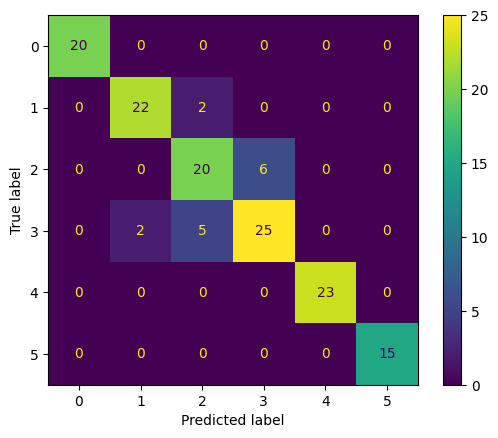

In [330]:
# Get the best model from your GridSearchCV object.
##  START CODE  ## (1 line of code)
net = gs.best_estimator_
##  END CODE  ##

# get predictions on the test data
##  START CODE  ## (1 line of code)
y_pred_test = net.predict(X_val)
y_pred_prob = net.predict_proba(X_val)[:, 1]
##  END CODE  ##

# calculate accuracy and print
print("Best Accuracy on Test: ", accuracy_score(y_val, y_pred_test))

# calculate confusion matrix and use ConfusionMatrixDisplay to display the matrix
##  START CODE  ##
confusion_mat = confusion_matrix(y_val, y_pred_test)
ConfusionMatrixDisplay(confusion_mat).plot()
##  END CODE  ##

# print sklearn's classification_report which consists of precision and recall for both labels
##  START CODE  ## (1 line of code)
print(classification_report(y_val, y_pred_test))
##  END CODE  ##

In [334]:
base_models = [
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=None, max_features='sqrt', min_samples_split=5, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42)),
    ('svc', SVC(kernel='linear', probability=True, random_state=42))
]

In [335]:
meta_model = LogisticRegression()

In [339]:
stacking_model = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=2)), 
    ('stack', StackingClassifier(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        verbose=1  # This enables detailed training output
    ))
])

In [340]:
stacking_model.fit(X_train_split, y_train_split)

Pipeline(steps=[('smote', SMOTE(k_neighbors=2, random_state=42)),
                ('stack',
                 StackingClassifier(cv=5,
                                    estimators=[('rf',
                                                 RandomForestClassifier(min_samples_split=5,
                                                                        n_estimators=50,
                                                                        random_state=42)),
                                                ('gb',
                                                 GradientBoostingClassifier(n_estimators=50,
                                                                            random_state=42)),
                                                ('svc',
                                                 SVC(kernel='linear',
                                                     probability=True,
                                                     random_state=42))],
                                    final_estimator=LogisticRegression(),
                                    verbose=1))])

In [341]:
y_val_pred = stacking_model.predict(X_val)
val_f1_score = f1_score(y_val, y_val_pred, average='weighted')
print("Stacked Model Validation F1 Score:", val_f1_score)
print("Stacked Model Classification Report:\n", classification_report(y_val, y_val_pred))

Stacked Model Validation F1 Score: 0.956575150874411
Stacked Model Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        20
         1.0       1.00      0.96      0.98        24
         2.0       0.95      0.81      0.88        26
         3.0       0.86      1.00      0.93        32
         4.0       1.00      1.00      1.00        23
         5.0       1.00      1.00      1.00        15

    accuracy                           0.96       140
   macro avg       0.97      0.96      0.96       140
weighted avg       0.96      0.96      0.96       140



In [347]:
y_test_pred = stacking_model.predict(X_test)

array([0, 3, 2, ..., 5, 4, 0])

In [351]:
test_df['label'] = y_test_pred
submission = test_df[['Id', 'label']]

In [354]:
submission.to_csv('NeuralNerds.csv', index=False)

In [358]:
y_sub = net.predict(X_test)
test_df['label'] = y_sub
submission = test_df[['Id', 'label']]
submission.to_csv('NeuralNerds.csv', index=False)